In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")
install.packages("readxl")

# Load necessary libraries
library(DESeq2)
library(ggplot2)
library(tidyverse)
library(readxl)
library(dplyr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘formatR’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'cli', 'diffobj'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGen

In [ ]:
packageVersion("DESeq2")

[1] ‘1.48.0’

In [ ]:
counts_data <- read.csv("/content/counts_file.csv")
counts_data <- na.omit(counts_data)
counts_data <- counts_data %>%
  column_to_rownames(var = "Geneid")
if (any(counts_data < 0)) { counts_data[counts_data < 0] <- 0 }
print(tail(counts_data))

condition <- read.table("/content/condition_file.txt", header = TRUE, fill = TRUE, row.names = 1)
batch <- read.csv("/content/batch_file.csv", header = TRUE, fill = TRUE, row.names = 1)

conditions <- as.vector(condition[, 1])
# Check if conditions and counts_data have matching column names
if (ncol(counts_data) != length(conditions)) {
  stop("Error: Number of conditions does not match the number of columns in counts_data")
}
colData <- data.frame(row.names = colnames(counts_data), condition = conditions, batch = batch)  # <-- Added batch to colData
colData$condition <- as.factor(colData$condition)

# Ensure "control" is a valid reference level
#if ("Control" %in% levels(colData$condition)) {
#  colData$condition <- relevel(colData$condition, ref = "Control")
#} else {
#  stop("Error: 'somthing wrong in condition' is not an existing level in the condition column.")
#}

condition_batch <- as.vector(batch[, 1]) # convert to vector
colData$batch <- condition_batch

print(colData)
print(nrow(counts_data))

                SRR21043448 SRR21043530 SRR21043687 SRR21043888 SRR21043816
ENSG00000169045        4179        2724        3843        2868        2317
ENSG00000163138           5           1           3           2           0
ENSG00000135486        2502        1949        2437        1850        1638
ENSG00000168488        1028         720        1010         861         660
ENSG00000111640        1648        1140        2313        1218        1104
ENSG00000108465         427         395         464         401         338
                SRR21043814 SRR21043817 SRR21043815
ENSG00000169045        3343        2554        2884
ENSG00000163138           3           2           3
ENSG00000135486        1998        1341        1854
ENSG00000168488         966         604         827
ENSG00000111640        1519        1007        1239
ENSG00000108465         435         291         378
            condition            batch
SRR21043448 Treatment Plate 2C index E
SRR21043530 Treatment Plat

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = counts_data, colData = colData, design = ~ condition)
filter2 <- rowSums(counts(dds) >= 10) > (ncol(dds) / 2) # strict filter
dds <- dds[filter2,]
print(dds)

class: DESeqDataSet 
dim: 9415 8 
metadata(1): version
assays(1): counts
rownames(9415): ENSG00000127837 ENSG00000090861 ... ENSG00000111640
  ENSG00000108465
rowData names(0):
colnames(8): SRR21043448 SRR21043530 ... SRR21043817 SRR21043815
colData names(2): condition batch


Spearmen condition that were followed in the paper:

In [ ]:
# VST makes variance  approximately constant across the range of mean values.
# Explanation: Reduces the differences in variability (spread) of gene expression levels between genes that are lowly expressed and those that are highly expressed.
vsd <- vst(dds, blind = FALSE)
vsd_mat <- assay(vsd)

# Calculate the Spearman correlation matrix, and keep the samples that meet the cutoff range
cor_matrix <- cor(vsd_mat, method = "spearman")
one_minus_spearman <- 1 - cor_matrix
#print(one_minus_spearman)
cutoff <- 0.1
samples_to_keep <- apply(one_minus_spearman, 2, function(x) any(x < cutoff & x > 0))
samples_names_to_keep <- colnames(one_minus_spearman)[samples_to_keep]
print(samples_names_to_keep)

[1] "SRR21043448" "SRR21043530" "SRR21043687" "SRR21043888" "SRR21043816"
[6] "SRR21043814" "SRR21043817" "SRR21043815"


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



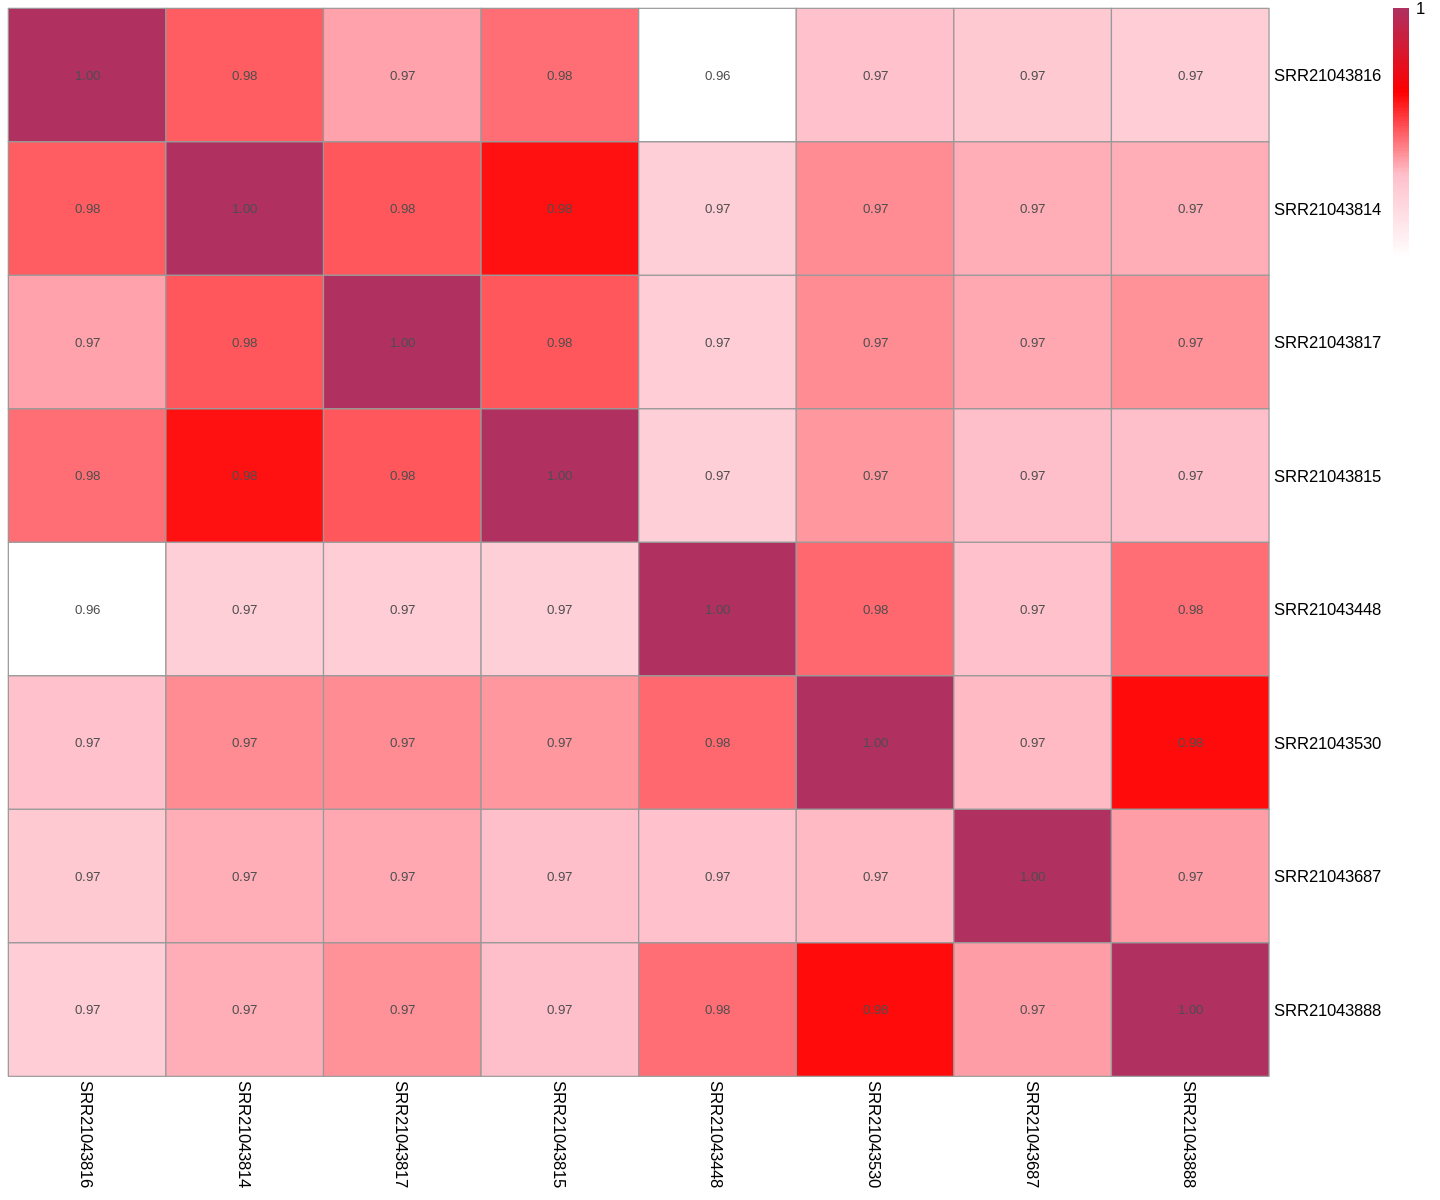

In [ ]:
install.packages("pheatmap")
library(pheatmap)
install.packages("RColorBrewer")
library(RColorBrewer)

sample_order <- order(colData$condition)
cor_matrix_copy <- cor_matrix[sample_order, sample_order]
ordered_conditions <- colData$condition[sample_order]

# Replace the row and column names in the correlation matrix with condition names
#rownames(cor_matrix_copy) <- ordered_conditions
#colnames(cor_matrix_copy) <- ordered_conditions
pheatmap(cor_matrix_copy,
         clustering_distance_rows = "correlation",
         clustering_distance_cols = "correlation",
         cluster_rows = FALSE,  # Disable clustering
         cluster_cols = FALSE,  # Disable clustering
         color = colorRampPalette(c("white","pink","red","maroon"))(100),
         legend = TRUE,  # Add legend for color
         legend_breaks = seq(-1, 1, 0.2),  # Define breaks for correlation values
         legend_labels = round(seq(-1, 1, 0.2), 2),  # Label the legend
         display_numbers = TRUE,  # Show correlation values on the heatmap
         fontsize_number = 8)  # Adjust font size for the correlation values

In [ ]:
dds <- DESeq(dds)
res <- results(dds)
summary(res)

significant_genes <- res[which(!is.na(res$padj) & res$padj < 0.05), ]
significant_genes_sorted <- significant_genes[order(significant_genes$padj), ]
print("Helloo!")
print(significant_genes_sorted)

# Create a dataframe to create file for gsea
write_res <- results(dds)
df <- data.frame(gene = rownames(write_res), stat = res$log2FoldChange)
df_sorted <- df[order(-df$stat), ]
x = readline()
write.csv(df_sorted, paste0("log2foldsorted_file_", x, ".csv"), row.names = FALSE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing




out of 9415 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 307, 3.3%
LFC < 0 (down)     : 479, 5.1%
outliers [1]       : 0, 0%
low counts [2]     : 3103, 33%
(mean count < 45)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

[1] "Helloo!"
log2 fold change (MLE): condition Treatment vs Control 
Wald test p-value: condition Treatment vs Control 
DataFrame with 480 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat      pvalue
                <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENSG00000047346   982.037      -0.628547 0.0872365  -7.20510 5.80030e-13
ENSG00000044574   639.596       0.935187 0.1439191   6.49801 8.13909e-11
ENSG00000148303   660.220       0.810772 0.1262489   6.42201 1.34483e-10
ENSG00000115268   800.373       0.653552 0.1023554   6.38512 1.71264e-10
ENSG00000115464   273.487      -0.844288 0.1405257  -6.00807 1.87748e-09
...                   ...     

In [ ]:
num_upregulated <- sum(significant_genes$log2FoldChange > 0)
num_downregulated <- sum(significant_genes$log2FoldChange < 0)

cat("Number of upregulated genes:", num_upregulated, "\n")
cat("Number of downregulated genes:", num_downregulated, "\n")

Number of upregulated genes: 176 
Number of downregulated genes: 304 


Creating the PCA plots for all conc

using ntop=500 top features by variance



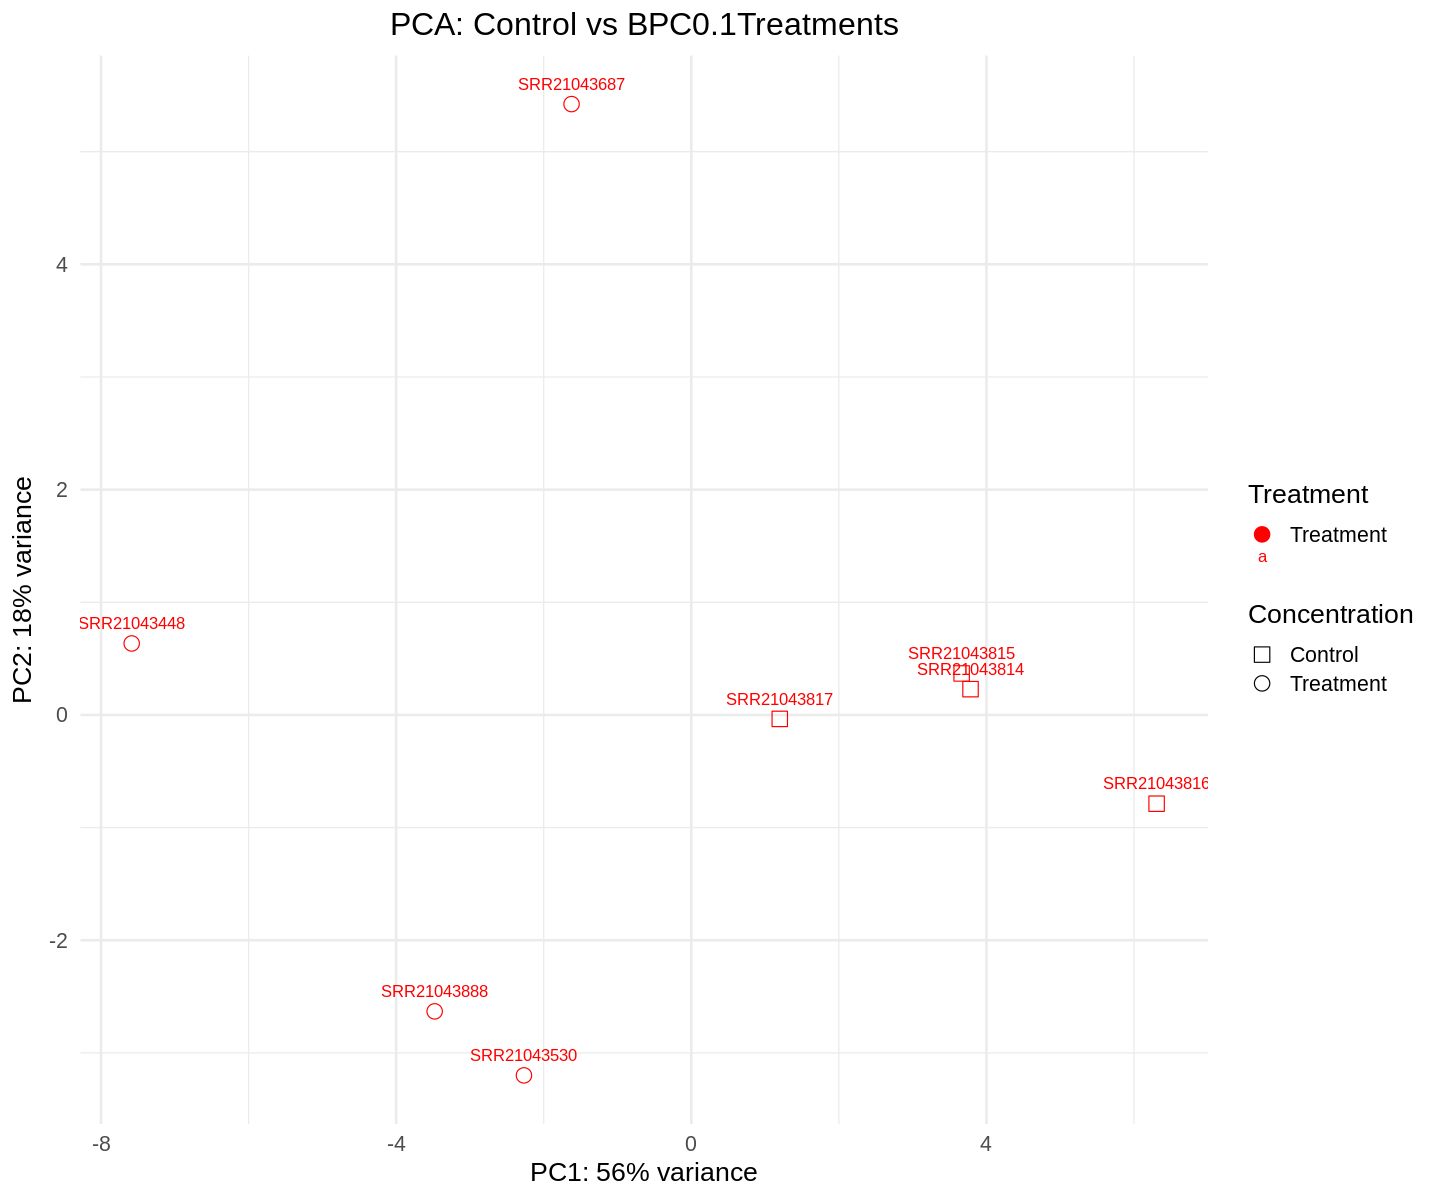

In [ ]:
library(ggplot2)
pcaData <- plotPCA(vsd, intgroup = "condition", returnData = TRUE)
percentVar <- round(100 * attr(pcaData, "percentVar"))
pcaData$Treatment <- ifelse(pcaData$condition == "DMSO", "Control", "Treatment")
pcaData$Treatment <- factor(pcaData$Treatment, levels = c("Control", "Treatment"))
pcaData$Concentration <- ifelse(
  pcaData$Treatment == "Control",
  "Control",
  gsub(".*\\[|\\]", "", pcaData$condition)
)
pcaData$Concentration <- as.factor(pcaData$Concentration)
pcaData$SampleID <- colnames(vsd_mat)
pcaData$SampleID <- colnames(vsd)
p <- ggplot(pcaData, aes(x = PC1, y = PC2, color = Treatment, shape = Concentration, label = SampleID)) +
  geom_point(size = 4) +
  geom_text(vjust = -1.2, size = 3.5, check_overlap = TRUE) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  scale_color_manual(
    values = c("Control" = "#ADD8E6", "Treatment" = "red"),
    name = "Treatment"
  ) +
  scale_shape_manual(
    values = 0:25,
    name = "Concentration"
  ) +
  guides(fill = "none", label = "none", group = "none") +
  theme_minimal(base_size = 16) +
  ggtitle(paste0("PCA: Control vs ",x,"Treatments"))+
  theme(plot.title = element_text(hjust = 0.5))
options(repr.plot.width = 12, repr.plot.height = 10)
print(p)

Warning message in scales::rescale(as.numeric(as.character(pcaData$Concentration)), :
“NAs introduced by coercion”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


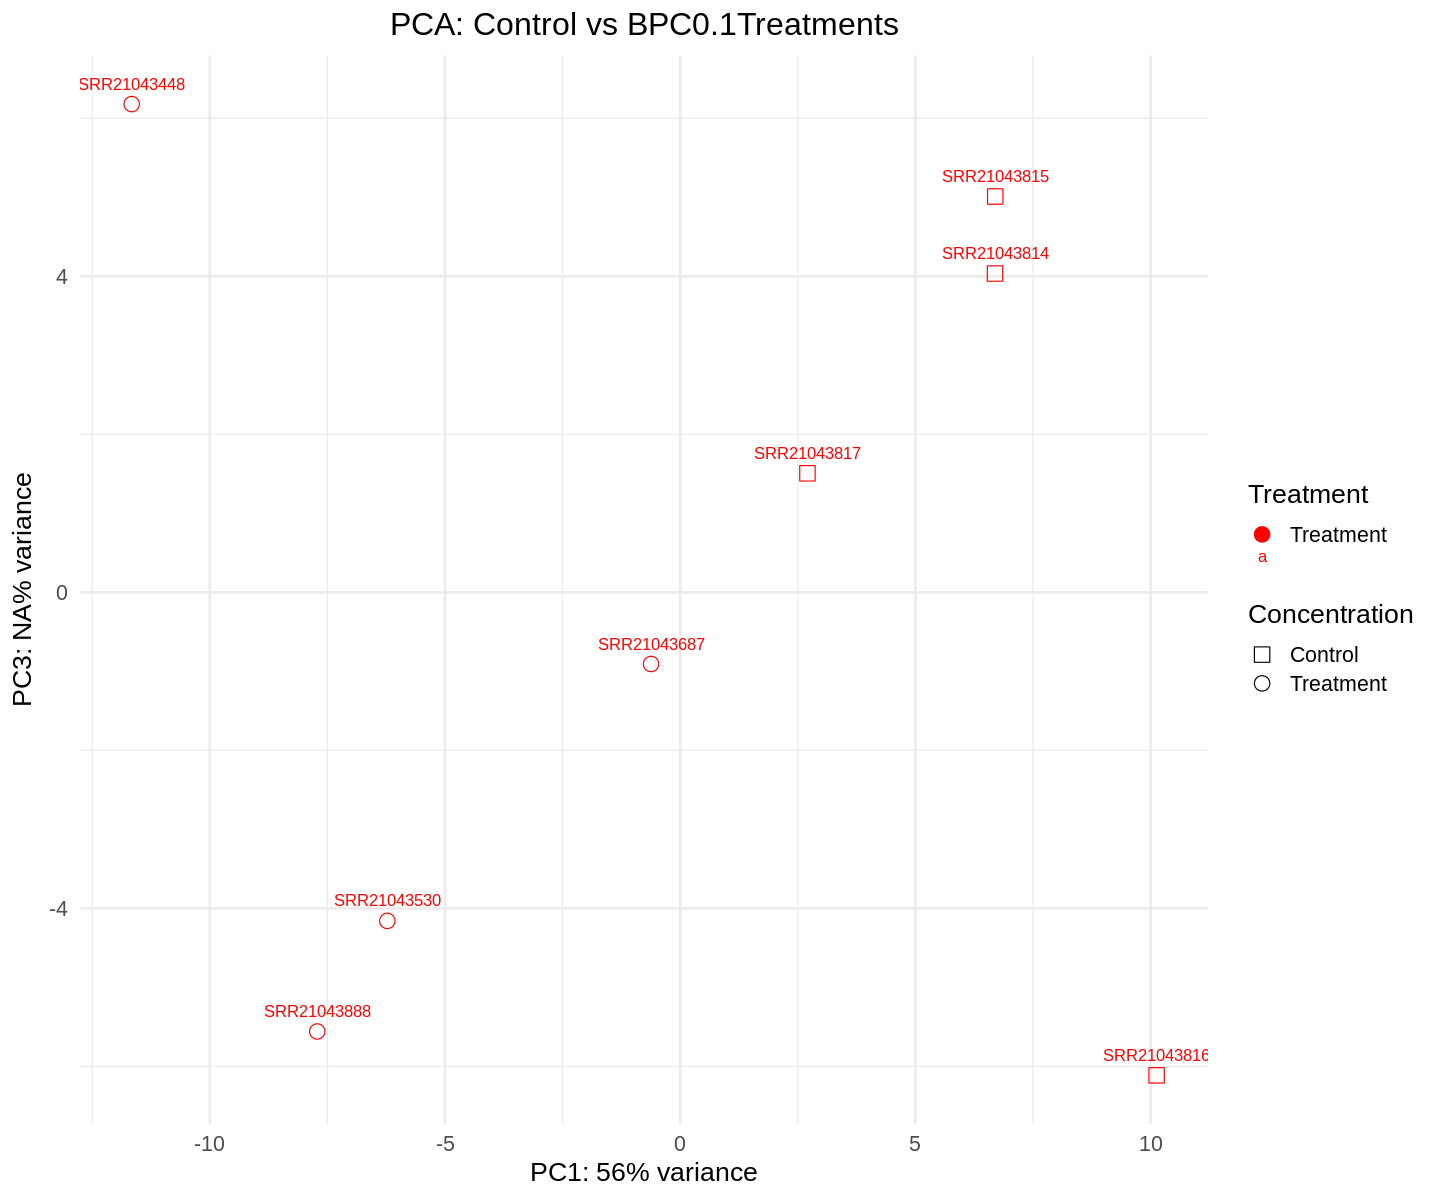

In [ ]:
vsd_mat <- assay(vsd)
pca <- prcomp(t(vsd_mat))
pcaData <- as.data.frame(pca$x[, 1:5])
pcaData$condition <- colData(vsd)$condition
pcaData$Treatment <- ifelse(pcaData$condition == "DMSO", "Control", "Treatment")
pcaData$Concentration <- ifelse(
  pcaData$Treatment == "Control",
  "Control",
  gsub(".*\\[|\\]", "", pcaData$condition)
)
pcaData$Concentration <- as.factor(pcaData$Concentration)
pcaData$SampleID <- colnames(vsd)
pcaData$PointSize <- ifelse(
  pcaData$Treatment == "Control",
  2,
  scales::rescale(as.numeric(as.character(pcaData$Concentration)), to = c(2, 6))
)
p <- ggplot(pcaData, aes(x = PC1, y = PC3, color = Treatment, shape = Concentration, label = SampleID)) +
  geom_point(size = 4) +
  geom_text(vjust = -1.2, size = 3.5, check_overlap = TRUE) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC3: ", percentVar[3], "% variance")) +
  scale_color_manual(values = c("Control" = "#ADD8E6", "Treatment" = "red")) +
  scale_shape_manual(values = 0:25) +
  theme_minimal(base_size = 16) +
  ggtitle(paste0("PCA: Control vs ",x,"Treatments")) +
  theme(plot.title = element_text(hjust = 0.5))
options(repr.plot.width = 12, repr.plot.height = 10)
print(p)

In [ ]:
pdf(paste0("DESeq2_report_", x, ".pdf"))
# MA plot (log fold change vs mean expression)
plotMA(res, main = "MA Plot", ylim = c(-5, 5))

# PCA plot to visualize sample clustering
vsd <- vst(dds, blind = FALSE)
plotPCA(vsd, intgroup = "condition")

# Dispersion plot to visualize gene variability
plotDispEsts(dds)

# Cook's distance for outlier detection (for one sample)
plot(seq_along(assays(dds)[["cooks"]][,1]), assays(dds)[["cooks"]][,1], type = "h",
     main = "Cook's Distance for Sample 1", xlab = "Genes", ylab = "Cook's Distance")

# Heatmap of sample distances
sampleDists <- dist(t(vsd_mat))
sampleDistMatrix <- as.matrix(sampleDists)
heatmap(sampleDistMatrix, symm = TRUE, main = "Sample Distance Heatmap")
# the heatmap made above is better so use that

# Close the PDF device
dev.off()

using ntop=500 top features by variance



pdf 
  2

Creating GCT file

In [ ]:
BiocManager::install("fgsea")
BiocManager::install("msigdbr")
if (!requireNamespace("AnnotationDbi", quietly = TRUE)) {
  BiocManager::install("AnnotationDbi")
}
if (!requireNamespace("org.Hs.eg.db", quietly = TRUE)) {
  BiocManager::install("org.Hs.eg.db")
}
BiocManager::install("msigdbr")
library(AnnotationDbi)
library(org.Hs.eg.db)
library(msigdbr)
library(fgsea)
library(stringr)
library(ggplot2)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'fgsea'”
Old packages: 'cli', 'diffobj'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.25), R 4.5.0 (2025-04-11)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'msigdbr'”
Old packages: 'cli', 'diffobj'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
R

In [ ]:
normalized_counts <- counts(dds, normalized=TRUE)
valid_rows <- !is.na(rownames(normalized_counts)) & rownames(normalized_counts) != ""
filtered_counts <- normalized_counts[valid_rows, ]
gene_symbols <- mapIds(
  org.Hs.eg.db,
  keys = rownames(filtered_counts),
  column = "SYMBOL",
  keytype = "ENSEMBL",
  multiVals = "first"
)
filtered_counts <- filtered_counts[!is.na(gene_symbols), ]
rownames(filtered_counts) <- gene_symbols[!is.na(gene_symbols)]
sample_metadata <- colData(dds)
if (!"condition" %in% colnames(sample_metadata)) {
  stop("Metadata does not contain a 'condition' column. Check your sample metadata.")
}
sample_metadata$condition <- tolower(sample_metadata$condition)
valid_conditions <- c("Treatment", "Control")
sample_metadata$condition <- ifelse(sample_metadata$condition %in% c("treatment", "treated"), "treatment",
                                    ifelse(sample_metadata$condition %in% c("control", "untreated"), "control", NA))

if (any(is.na(sample_metadata$condition))) {
  stop("Unexpected condition values found in sample metadata. Ensure all samples are labeled as 'treatment' or 'control'.")
}
sample_metadata$condition <- factor(sample_metadata$condition, levels = valid_conditions)
sample_names_before <- rownames(sample_metadata)
conditions_before <- sample_metadata$condition
sorted_sample_names <- rownames(sample_metadata)[order(sample_metadata$condition)]
sample_names_after <- sorted_sample_names
conditions_after <- sample_metadata$condition[order(sample_metadata$condition)]
message("Sample order before sorting: ", paste(sample_names_before, conditions_before, sep=":", collapse=", "))
message("Sample order after sorting: ", paste(sample_names_after, conditions_after, sep=":", collapse=", "))
filtered_counts <- filtered_counts[, sorted_sample_names]
if (!all(colnames(filtered_counts) == sorted_sample_names)) {
  stop("Error: Column names in filtered_counts do not match sorted sample names. Possible mismatch detected.")
}
write_gct <- function(data_matrix, output_file) {
  num_genes <- nrow(data_matrix)
  num_samples <- ncol(data_matrix)
  fileConn <- file(output_file, "w")
  writeLines("#1.2", fileConn)
  writeLines(paste(num_genes, num_samples, sep="\t"), fileConn)
  gene_ids <- rownames(data_matrix)
  description <- ifelse(is.na(gene_ids) | gene_ids == "", "Unknown", "NA")  # Handle missing descriptions
  gct_data <- cbind(Name=gene_ids, Description=description, data_matrix)
  write.table(gct_data, file=fileConn, sep="\t", row.names=FALSE, col.names=TRUE, quote=FALSE)
  close(fileConn)
}
output_file <- paste0("deseq_normalized_counts_for_", x, ".gct")
write_gct(filtered_counts, output_file)
message("GCT file successfully written: ", output_file)

'select()' returned 1:many mapping between keys and columns

Sample order before sorting: SRR21043448:NA, SRR21043530:NA, SRR21043687:NA, SRR21043888:NA, SRR21043816:NA, SRR21043814:NA, SRR21043817:NA, SRR21043815:NA

Sample order after sorting: SRR21043448:NA, SRR21043530:NA, SRR21043687:NA, SRR21043888:NA, SRR21043816:NA, SRR21043814:NA, SRR21043817:NA, SRR21043815:NA

GCT file successfully written: deseq_normalized_counts_for_BPC0.1.gct



In [ ]:
write_res <- results(dds)
gene_symbols <- mapIds(
  org.Hs.eg.db,
  keys = rownames(write_res),
  column = "SYMBOL",
  keytype = "ENSEMBL",
  multiVals = "first"
)
gene_symbols <- as.character(gene_symbols)
gene_symbols[is.na(gene_symbols)] <- rownames(write_res)[is.na(gene_symbols)]
stopifnot(length(gene_symbols) == nrow(write_res)) # check
df <- data.frame(
  gene = gene_symbols,           # Gene symbols
  ensembl_id = rownames(write_res),  #  Ensembl IDs
  stat = write_res$padj,         # Adjusted p-values
  log2FoldChange = write_res$log2FoldChange,  # Log2 fold change
  pvalue = write_res$pvalue,     # Raw p-values
  baseMean = write_res$baseMean,  # Mean of normalized counts
  stringsAsFactors = FALSE       # ?
)
df <- df %>% filter(!is.na(stat) & !is.na(log2FoldChange) & !is.na(pvalue) & !is.na(baseMean))
df_sorted <- df[order(df$stat, na.last = TRUE), ]
write.csv(df_sorted, "fileFORbiostatsquidALLSTAT.csv", row.names = FALSE)
cat("File successfully saved: fileFORbiostatsquidALLSTAT.csv\n")

'select()' returned 1:many mapping between keys and columns



File successfully saved: fileFORbiostatsquidALLSTAT.csv


In [ ]:
gene_symbols[is.na(gene_symbols)] <- rownames(write_res)[is.na(gene_symbols)]
df <- data.frame(
  gene = gene_symbols,           # Gene symbols
  ensembl_id = rownames(write_res),  # Ensembl IDs for reference
  stat = write_res$padj,         # Adjusted p-values
  log2FoldChange = write_res$log2FoldChange,  # Log2 fold change
  stringsAsFactors = FALSE       # ?
)
df <- df %>% filter(!is.na(stat) & !is.na(log2FoldChange))
df_sorted <- df[order(df$stat, na.last = TRUE), ]
significant_genes <- df_sorted[which(!is.na(df_sorted$stat) & df_sorted$stat < 0.05), ]
write.csv(significant_genes, paste0("sigGenes_", x, ".csv"), row.names = FALSE)